In [15]:
import numpy as np
from numpy.random import rand
from scipy.spatial import SphericalVoronoi
from matplotlib import colors
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from scipy.spatial.distance import pdist, squareform, euclidean
import time
import pickle

In [16]:
from scipy import optimize
import copy

In [17]:
from random import randint

In [52]:
class BestOptimizer:
    def __init__(self, N, maxiter = 200, points = [], alpha = 0.4, step_type = '3D', init_type = 'generalized_spiral'):
        self.N = N
        self.maxiter = maxiter
        self.points = points
        self.alpha = alpha
        self.step_type = step_type
        self.init_type = init_type


    def init_points(self, type):
        np.random.seed(42)
        self.points = -1.0 + 2.0*rand(self.N, 3)
        if type == 'polar':
            for i in range(self.N):
                self.points[i][0] *= 0.1
                self.points[i][1] *= 0.1
                self.points[i][2] = self.points[i][0]*0.1 + 1.0
        elif type == 'equidistant':
            N = 0
            a = 4*np.pi/self.N
            d = np.sqrt(a)
            Mth = int(np.pi/d)
            dth = np.pi/Mth
            dph = a/dth
            for m in range(Mth):
                th = np.pi*(m+0.5)/Mth
                Mph = int(2*np.pi*np.sin(th)/dth)
                for n in range(Mph):
                    ph = 2*np.pi*n/Mph
                    self.points[N] = np.array([np.sin(th)*np.cos(ph), np.sin(th)*np.sin(ph), np.cos(th)])
                    N+=1
            i = 0
            for p in range(N, self.N):
                i+=1
                self.points[p] = (self.points[i] + self.points[i+1])/2.0
        elif type == 'generalized_spiral':
            C = 3.6
            h = np.zeros(self.N, dtype  = float)
            th = np.zeros(self.N)
            ph = np.zeros(self.N)
            for k in range(self.N):
                h[k] = -1.0+2.0*k/self.N
                th[k] = np.arccos(h[k])
                if (k!=0 and k!=self.N-1):
                    ph[k] = (ph[k-1]+C/np.sqrt(self.N+1.0)/np.sqrt(1.0-h[k]**2))%(2*np.pi)
                self.points[k] = np.array([np.sin(th[k])*np.cos(ph[k]), np.sin(th[k])*np.sin(ph[k]), np.cos(th[k])])
        else:
            pass
        for i in range(self.N):
            self.points[i] = self.points[i]/np.linalg.norm(self.points[i])

    def choose_alpha(self, idx):
        grad_estim = 0
        for i in range(self.N):
            if i != idx:
                grad_estim += (self.points[idx]-self.points[i])/self.pairwise[i][idx]**3
        L = 4*euclidean(grad_estim, 0)
        self.alpha = 1.0/L
        
    def choose_alpha_avg(self, idx):
        avg_dist = 0
        for i in range(self.N):
            if i != idx:
                avg_dist += 1.0/self.pairwise[i][idx]**3
        avg_dist /= self.N
        self.alpha = 1.0/(18.0*avg_dist)
        
    def choose_alpha_once(self, idx):
        L = (self.N-1.0)**(1.0+2)*1.0/2**(1.0+1)
        self.alpha = 1/L

    def count_energy(self):
        min_energy = 0
        for i in range(self.N):
            for j in range(self.N):
                if i > j:
                    min_energy += 1.0/self.pairwise[i][j]
        return min_energy

    def choose_point(self):
        pairs = self.pairwise.copy()
        for i in range(self.N):
            pairs[i][i] = 0
        idxs = np.argwhere(self.pairwise < np.mean(pairs)/4.0)
        if len(idxs) == 0:
            idxs = np.argmin(self.pairwise)
            return np.unravel_index(idxs, (self.N, self.N))[np.random.randint(2)]
        else:
            return idxs[np.random.randint(len(idxs))][np.random.randint(2)]

    def grad_point(self, idx):
        grad = np.zeros(3)
        for i in range(len(self.points)):
            if idx != i:
                grad += -(self.points[idx]-self.points[i])/(self.pairwise[idx][i])**3
        return grad
    
    def grad_full(self):
        grad = np.zeros(3*self.N)
        for i in range(self.N):
            grad[i:i+3] = self.grad_point(i)
        return grad

    def fix_point_in_pairwise(self, idx):
        for i in range(len(self.points)):
            if i != idx:
                self.pairwise[i][idx], self.pairwise[idx][i] = (euclidean(self.points[i], self.points[idx]),)*2

    def fix_pairwise(self):
        for i in range(self.N):
            for j in range(self.N):
                if i > j:
                    self.pairwise[i][j], self.pairwise[j][i] = (euclidean(self.points[i], self.points[j]),)*2

    def Gradient_descent(self):
        energies = []
        iter_points = []
        #Choose initial position - "generalized spiral"
        if self.points == []:
            self.init_points(type = self.init_type)
        self.pairwise = squareform(pdist(self.points))
        for i in range(self.N):
            self.pairwise[i][i] = np.inf
        self.choose_alpha(0)
        print (self.alpha)
        min_energy = self.count_energy()
        energies.append(min_energy)
        for it in range(self.maxiter):
            #print float(it)/self.maxiter*100, '%'
            #idx = self.choose_point()
            idx = it%self.N
            #idx = randint(0, self.N-1)
            if self.step_type == 'tangent_plane':
                self.choose_alpha(idx)
                grad = -self.grad_point(idx)
                point = self.points[idx].copy()
                h = grad - np.dot(grad, point)*point
                point += self.alpha*h
            elif self.step_type == '3D':
                self.choose_alpha(idx)
                point = copy.deepcopy(self.points[idx] - self.alpha*self.grad_point(idx))
            point /= np.linalg.norm(point)
            self.points[idx] = point
            self.fix_point_in_pairwise(idx)
            min_energy = self.count_energy()
            energies.append(min_energy)
            iter_points.append(copy.deepcopy(self.points))

        #print
        return energies, self.points, iter_points

    def Count_Full_Hess(self):
        self.Hess = np.zeros((3*self.N, 3*self.N))
        for i in range(self.N):
            for j in range(self.N):
                if i != j:
                    pair_vec = self.points[i]-self.points[j]
                    pair_dist = self.pairwise[i][j]
                    self.Hess[3*i:3*i+3,3*j:3*j+3] = (np.identity(3)*(pair_dist)**2 - 3*np.outer(pair_vec, pair_vec))/(pair_dist**5)
                if i == j:
                    diag_block_sum = np.zeros((3,3))
                    for k in range(self.N):
                        if k != i:
                            pair_vec = self.points[i]-self.points[k]
                            pair_dist = self.pairwise[i][k]
                            diag_block_sum += (np.identity(3)*(pair_dist)**2 + 3*np.outer(pair_vec, pair_vec))/(pair_dist**5)
                    self.Hess[3*i:3*i+3,3*i:3*i+3] = diag_block_sum

    def Newton_all_points(self):
        energies = []
        iter_points = []
        if self.points == []:
            self.init_points(type = self.init_type)
        self.pairwise = squareform(pdist(self.points))
        min_energy = self.count_energy()
        energies.append(min_energy)
        for i in range(self.N):
            self.pairwise[i][i] = np.inf
        for it in range(self.maxiter):
            #print (round(float(it)/self.maxiter*100, 1), '%')
            self.Count_Full_Hess()
            self.points += -np.dot(np.linalg.inv(self.Hess), self.grad_full()).reshape(self.N, 3)
            for i in range(self.N):
                self.points[i] /= np.linalg.norm(self.points[i])
            self.fix_pairwise()
            min_energy = self.count_energy()
            energies.append(min_energy)
            iter_points.append(copy.deepcopy(self.points))
            
        return energies, self.points, iter_points

    def Count_3D_Hess(self, idx):
        Hess_1 = np.zeros((3,3))
        for k in range(self.N):
            if k != idx:
                pair_vec = self.points[idx]-self.points[k]
                pair_dist = self.pairwise[idx][k]
                Hess_1 += (-np.identity(3)*(pair_dist**2) + 3*np.outer(pair_vec, pair_vec))/(pair_dist**5)
        return Hess_1
    
    def solve_for_mu(self, l, b):
        coeff = np.zeros(7)
        l0 = l[0]
        l1 = l[1]
        l2 = l[2]
        b0s = b[0]**2
        b1s = b[1]**2
        b2s = b[2]**2
        coeff[0] = 1.0
        coeff[1] = 2*np.sum(l)
        coeff[2] = np.sum(l)**2 + 2*(l0*l1+l0*l2+l1*l2) - (b0s + b1s + b2s)
        coeff[3] = 2*(l0*l1*(l0+l1) + l0*l2*(l0+l2) + l2*l1*(l2+l1)) + 8*l0*l1*l2 - 2*(b0s*(l1+l2) + b1s*(l0+l2) + b2s*(l0+l1))
        coeff[4] = (l0*l1)**2+(l0*l2)**2+(l1*l2)**2 + 4*l0*l1*l2*(np.sum(l)) - ( ((l0+l1)**2 + 2*l0*l1)*b2s + ((l0+l2)**2 + 2*l0*l2)*b1s + ((l2+l1)**2 + 2*l2*l1)*b0s)
        coeff[5] = 2*l0*l1*l2*(l0*l1+l0*l2+l1*l2) - 2*( b2s*l0*l1*(l0+l1) + b1s*l0*l2*(l0+l2) + b0s*l2*l1*(l2+l1) )
        coeff[6] = (l0*l1*l2)**2 - (b2s*(l0*l1)**2 + b1s*(l0*l2)**2 + b0s*(l1*l2)**2)
        roots = np.roots(coeff)
        real_roots = roots[np.isreal(roots)]
        mu = np.real(np.max(real_roots))
        if mu > -np.min(l):
            return mu
        else:
            print ('maybe it is Degenerate case?')
            return mu

    def Solve_Quadratic(self, A, b, idx):
        def constraint(x):
            return np.sum(x**2)-1.0
        def constraint2(x):
            return -np.sum((x-self.points[idx])**2) + 1.0/np.sqrt(self.N)
        def f(x):
            return np.dot(np.dot(A, x), x) - 2*np.dot(b, x)

        #res = optimize.minimize(f, self.points[idx], method="SLSQP",
        #                     constraints=({"fun": constraint, "type": "eq"}, {"fun": constraint2, "type": "ineq"}))
        res = optimize.minimize(f, self.points[idx], method="SLSQP",
                             constraints={"fun": constraint, "type": "eq"})
      
        '''
        EigVals, EigVecs = np.linalg.eig(A)
        bettas = np.dot(b, EigVecs)
        minVal = np.min(EigVals)
        E1 = np.argwhere(EigVals == minVal).flatten()
        E_plus = np.argwhere(EigVals != minVal).flatten()
        if np.all(bettas[E1]) == 0 and np.sum((betta[E_plus] / (EigVals[E_plus] - minVal) )**2) <= 1:
            print ('Degenerate case!')
        else:
            mu = self.solve_for_mu(EigVals, bettas)
            c = bettas / (EigVals + mu)
            sol = np.zeros(3)
            for i in range(3):
                sol += c[i]*EigVecs[i]
               '''
       # print (np.sqrt(np.sum((res.x-self.points[idx])**2)))
        return res.x

    def Newton_coordinate_quadratic(self):
        energies = []
        iter_points = []
        if list(self.points) == []:
            self.init_points(type = self.init_type)
        self.pairwise = squareform(pdist(self.points))
        for i in range(self.N):
            self.pairwise[i][i] = np.inf
        self.count_energy()
        energies.append(self.count_energy())
        Newton_vs_grad = 0.0
        for it in range(self.maxiter):
            idx = it%self.N
            #idx = randint(0, self.N-1)
            point = self.points[idx]
            Hess_1 = self.Count_3D_Hess(idx = idx)
            
            if np.all(np.linalg.eigvals(Hess_1) >= 0):
                point = self.Solve_Quadratic(Hess_1, 0.5*(np.dot(Hess_1, point) - self.grad_point(idx)), idx)
                Newton_vs_grad += 1.0
            else:
                self.choose_alpha(idx)
                point = copy.deepcopy(self.points[idx] - 0.1*self.alpha*self.grad_point(idx))
            
            point /= np.linalg.norm(point)
            self.points[idx] = copy.deepcopy(point)
            self.fix_point_in_pairwise(idx)
            energies.append(self.count_energy())
                        
            iter_points.append(copy.deepcopy(self.points))
        print("Newton_vs_grad: ", Newton_vs_grad/float(self.maxiter))
        return energies, self.points,iter_points

    def Newton_coordinate_conv(self):
        energies = []
        iter_points = []
        if self.points == []:
            self.init_points(type = self.init_type)
        self.pairwise = squareform(pdist(self.points))
        for i in range(self.N):
            self.pairwise[i][i] = np.inf
        energies.append(self.count_energy())
        for it in range(self.maxiter):
            idx = it%self.N
            point = self.points[idx]
            Hess_1 = self.Count_3D_Hess(idx = idx)
            point = point - np.dot(np.linalg.inv(Hess_1), self.grad_point(idx))
            point /= np.linalg.norm(point)
            self.points[idx] = point
            self.fix_point_in_pairwise(idx)
            energies.append(self.count_energy())
            iter_points.append(copy.deepcopy(self.points))

        return energies, self.points, iter_points


# Generalized spiral investigation

In [53]:
N0 = 100
Maxiter = 1
start = time.time()
opt = BestOptimizer(N = N0, maxiter = Maxiter, init_type = 'generalized_spiral', step_type = '3D')
energies, points, iter_points = opt.Gradient_descent()
end = time.time()
print ('time: ', end-start)

0.004878470136783807
time:  0.014094114303588867


# Оценка скорости сходимости градиентного спуска

In [59]:
N0 = 111
Maxiter = 1000
start = time.time()
opt = BestOptimizer(N = N0, maxiter = Maxiter, init_type = 'polar', step_type = '3D')
energies, points, iter_points = opt.Gradient_descent()
end = time.time()
print ('time: ', end-start)

5.929691601647878e-06
time:  5.1360368728637695


In [57]:
p = points

In [74]:
X = iter_points - p
Iter_X = np.zeros(Maxiter)
for i in range(Maxiter):
    Iter_X[i] = euclidean(X[i].flatten(), 0)

In [75]:
Iter_X

array([4.56753479e+00, 4.56749940e+00, 4.56686356e+00, ...,
       3.04669844e-05, 3.00974914e-05, 2.97984707e-05])

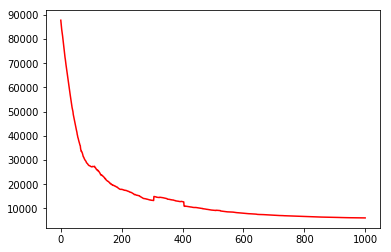

In [60]:
plt.plot(range(len(energies)), energies, c = 'r')
plt.show()
#plt.plot(range(Maxiter), np.log(Iter_X))

# Метод Ньютона

In [371]:
N0 = 50
start = time.time()
opt = BestOptimizer(N = N0, maxiter = 2000, init_type = 'polar', step_type = '3D')
energies_Newton_coordinate_quadratic_polar, points_Newton_coordinate_quadratic_polar, iter_points_Newton_coordinate_quadratic_polar = opt.Newton_coordinate_quadratic()
opt = BestOptimizer(N = N0, maxiter = 2000, init_type = 'generalized_spiral', step_type = '3D')
energies_Newton_coordinate_quadratic, points_Newton_coordinate_quadratic, iter_points_Newton_coordinate_quadratic = opt.Newton_coordinate_quadratic()
end = time.time()
print ('time: ', end-start)

Newton_vs_grad:  0.0
Newton_vs_grad:  0.0
time:  11.731261968612671


(500, 10070)

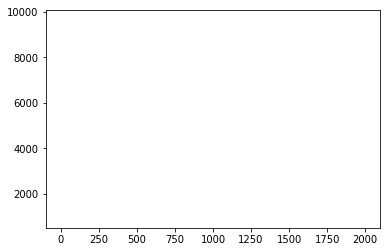

In [369]:
plt.plot(range(len(energies_Newton_coordinate_quadratic_polar)), energies_Newton_coordinate_quadratic_polar, c = 'r')
plt.plot(range(len(energies_Newton_coordinate_quadratic)), energies_Newton_coordinate_quadratic, c = 'b')
plt.ylim(500, 10070)

In [296]:
N0 = 150
start = time.time()
opt = BestOptimizer(N = N0, maxiter = 10000, points = points_Newton_coordinate_quadratic_polar, init_type = 'polar', step_type = '3D')
energies_Newton_coordinate_quadratic_polar2, points_Newton_coordinate_quadratic_polar2, iter_points_Newton_coordinate_quadratic_polar2 = opt.Newton_coordinate_quadratic()
opt = BestOptimizer(N = N0, maxiter = 10000, points = points_Newton_coordinate_quadratic, init_type = 'generalized_spiral', step_type = '3D')
energies_Newton_coordinate_quadratic2, points_Newton_coordinate_quadratic2, iter_points_Newton_coordinate_quadratic2 = opt.Newton_coordinate_quadratic()
end = time.time()
print ('time: ', end-start)

time:  231.8372619152069


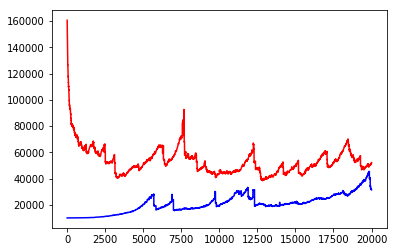

In [297]:
plt.plot(range(len(energies_Newton_coordinate_quadratic_polar)), energies_Newton_coordinate_quadratic_polar, c = 'r')
plt.plot(range(len(energies_Newton_coordinate_quadratic)), energies_Newton_coordinate_quadratic, c = 'b')
plt.plot(range(10000,10000+len(energies_Newton_coordinate_quadratic_polar2)), energies_Newton_coordinate_quadratic_polar2, c = 'r')
plt.plot(range(10000,10000+len(energies_Newton_coordinate_quadratic2)), energies_Newton_coordinate_quadratic2, c = 'b')

In [111]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import numpy as np
plotly.offline.init_notebook_mode(connected = True)
x, y, z = iter_points_Newton_coordinate_quadratic[:,0], iter_points_Newton_coordinate_quadratic[:,1], iter_points_Newton_coordinate_quadratic[:,2]
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
    )
)
theta = np.linspace(0,2*np.pi,100)
phi = np.linspace(0,np.pi,100)
x = np.outer(np.cos(theta),np.sin(phi))
y = np.outer(np.sin(theta),np.sin(phi))
z = np.outer(np.ones(100),np.cos(phi)) 

trace2 = go.Surface(
        x=x,
        y=y,
        z=z
    )

layout = go.Layout(
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=1
    )
)
fig = go.Figure(data = [trace2, trace1], layout = layout)
plotly.offline.iplot(fig)

In [112]:
def animate_one(iter_points):
    frames = []
    n_iter = len(iter_points)
    theta = np.linspace(0,2*np.pi,100)
    phi = np.linspace(0,np.pi,100)
    x1 = np.outer(np.cos(theta),np.sin(phi))
    y1 = np.outer(np.sin(theta),np.sin(phi))
    z1 = np.outer(np.ones(100),np.cos(phi)) 

    data = [go.Scatter3d(x = iter_points[0][:,0],
                        y = iter_points[0][:,1],
                        z = iter_points[0][:,2])]
    
    for epoch in range(n_iter):
        frames.append({'data': [go.Scatter3d(x = iter_points[epoch][:,0], y = iter_points[epoch][:,1], z = iter_points[epoch][:,2])]})
    
    figure = {
            
          'data': data,
        
          'layout': {'scene': {'zaxis': {'range': [-1, 1], 'autorange': False, 'showbackground' : True,}},
                     'updatemenus': [{'type': 'buttons',
                                      'buttons': [{'label': 'Play',
                                                   'method': 'animate',
                                                   'args': [
                                    None, 
                                    dict(frame=dict(duration=70, redraw=False),
                                         transition=dict(duration=50),
                                         fromcurrent=True,
                                         mode='immediate')
                                ]}]}]
                    },
          'frames': frames
         }

    plotly.offline.iplot(figure)

In [235]:
a = iter_points[-50:]

In [239]:
a = np.array(iter_points_Newton_coordinate_quadratic)[130:160]

In [240]:
animate_one(a)

In [9]:
with open('XYZ, ' + str(N0)+'.pk', 'wb') as f:
    pickle.dump(points_Newton_conv, f)
    pickle.dump(energies_Newton_conv, f)

In [26]:
def plot_Voronoi(pointsXYZ):
    sv = SphericalVoronoi(pointsXYZ)

    sv.sort_vertices_of_regions()
    # generate plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # plot the unit sphere for reference (optional)
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color='y', alpha=0.1)
    # plot generator points
    ax.scatter(pointsXYZ[:, 0], pointsXYZ[:, 1], pointsXYZ[:, 2], c='b', s = 2)
    # plot Voronoi vertices
    #ax.scatter(sv.vertices[:, 0], sv.vertices[:, 1], sv.vertices[:, 2], c='g')
    # indicate Voronoi regions (as Euclidean polygons)
    for region in sv.regions:
        random_color = colors.rgb2hex(np.random.rand(3))
        polygon = Poly3DCollection([sv.vertices[region]], alpha=1.0)
        if len(sv.vertices[region]) == 3:
            polygon.set_color('pink')
        elif len(sv.vertices[region]) == 4:
            polygon.set_color('yellow')
        elif len(sv.vertices[region]) == 5:
            polygon.set_color('red')
        elif len(sv.vertices[region]) == 6:
            polygon.set_color('green')
        elif len(sv.vertices[region]) == 7:
            polygon.set_color('black')
        else:
            polygon.set_color(random_color)
        polygon.set_edgecolor('black')
        ax.add_collection3d(polygon)
    plt.show()

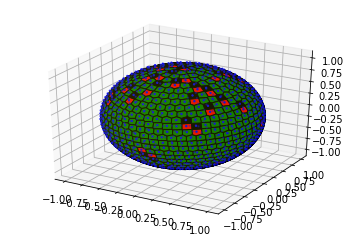

In [27]:
plot_Voronoi(points)

In [ ]:
def Solve_Quadratic(A, b, idx):
        def constraint(x):
            return np.sum(x**2)-1.0
        def f(x):
            return np.dot(np.dot(A, x), x) - 2*np.dot(b, x)

        res = optimize.minimize(f, , method="SLSQP",
                             constraints={"fun": constraint, "type": "eq"})

        return res.x